In [2]:
# Package imports
import random
from random import randint
import time

import os
import json
import string
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import contextily as cx
import warnings
import shapely
from shapely.geometry import Point, Polygon, LineString, LinearRing
from shapely import oriented_envelope, affinity
import math
from tqdm import tqdm
 
# prints parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 21 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


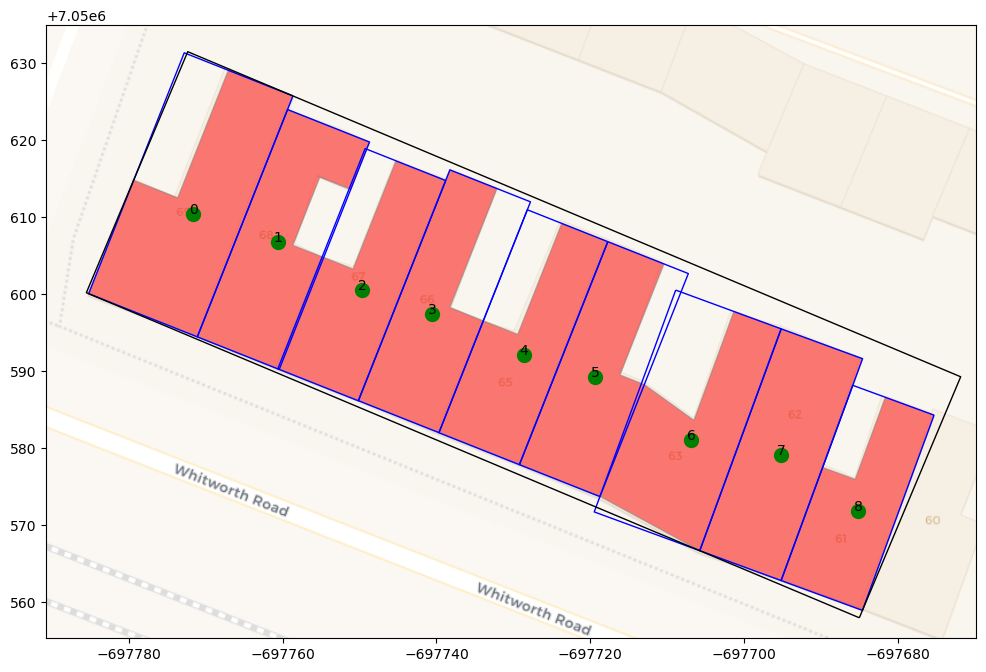

In [22]:
gdf = gpd.read_file(f'{parent_dir}/geojson_polygons/whitworth_buildings.geojson')
convert = True
if convert and gdf.crs == 'EPSG:4326':
    gdf = gdf.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(12,8))
gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf['coords'] = [coords[0] for coords in gdf['coords']]
gdf['name'] = [idx for idx in range(len(gdf))]

gdf_subset = gdf.iloc[933:942]
gdf_subset['mbr'] = gdf_subset['geometry'].apply(lambda x: oriented_envelope(x))

poly_933 = gdf_subset.iloc[0]['geometry']
gdf_subset['name'] = [idx for idx in range(len(gdf_subset))]

gdf_subset.plot(ax=ax, edgecolor='grey', facecolor='red', alpha=0.5)
gdf_subset['mbr'].plot(ax=ax, edgecolor='blue', facecolor='none')
gdf_subset['geometry'].centroid.plot(ax=ax, color='green', markersize=100)


cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

gdf_subset.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

oriented_envelope(gdf_subset.dissolve()['geometry']).plot(ax=ax, edgecolor='black', facecolor='none')

plt.show()

<class 'geopandas.geoseries.GeoSeries'>


AttributeError: 'Polygon' object has no attribute 'plot'

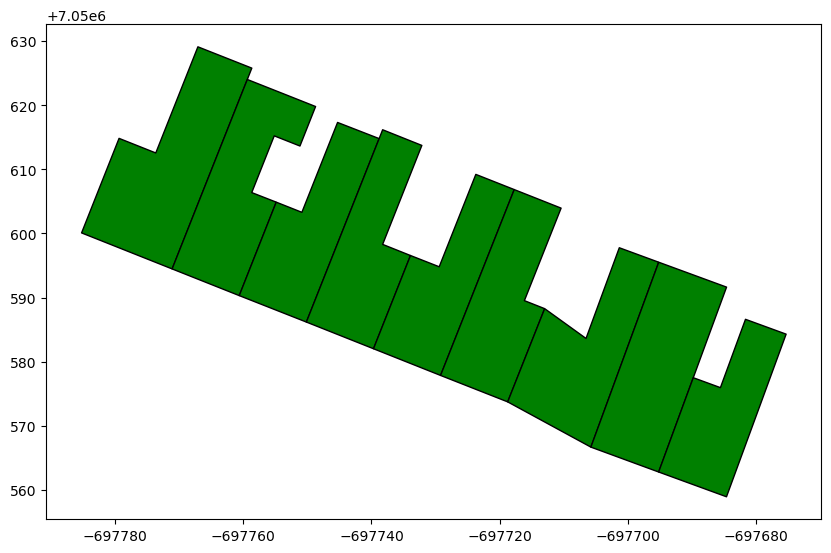

In [31]:
def move_poly(poly_old, c_new):
    x_old, y_old = poly_old.centroid.x, poly_old.centroid.y
    x_new, y_new = c_new.x, c_new.y

    delta_x = x_new - x_old
    delta_y = y_new - y_old
    poly_new = affinity.translate(poly_old, xoff=delta_x, yoff=delta_y)

    print("Pre-Move:", poly_old)
    print("Post-Move:", poly_new)

    return poly_new

def poly_swap(poly_a, poly_b):
    poly_temp = poly_a
    poly_a = move_poly(poly_a, poly_b.centroid)
    poly_b = move_poly(poly_b, poly_temp.centroid)
    return poly_a, poly_b

fig, ax = plt.subplots(1,1,figsize=(10,8))

poly_list = gdf_subset['geometry']

print(type(poly_list))

poly_list.plot(ax=ax, edgecolor='black', facecolor='green')
oriented_envelope(shapely.ops.unary_union(poly_list)).plot(ax=ax, edgecolor='grey', facecolor='pink')